In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ukdataset-use-ridge-csv/ridge.csv
/kaggle/input/road-traffic-accidents/RTA Dataset.csv
/kaggle/input/road-traffic-accidents/cleaned.csv


In [2]:
da = pd.read_csv('/kaggle/input/ukdataset-use-ridge-csv/ridge.csv')


In [3]:
da.columns

Index(['Unnamed: 0', 'Longitude', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Road_Type', 'Junction_Control', 'Pedestrian_Crossing-Human_Control',
       'Light_Conditions', 'Carriageway_Hazards', 'Urban_or_Rural_Area',
       'Did_Police_Officer_Attend_Scene_of_Accident', 'Accident_Severity'],
      dtype='object')

In [4]:
df = pd.read_csv('/kaggle/input/road-traffic-accidents/RTA Dataset.csv')
df.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [5]:
df.shape

(12316, 32)

 99%|===================| 5722/5757 [01:06<00:00]       


📊 SHAP Summary Plot (Beeswarm) for Class 0


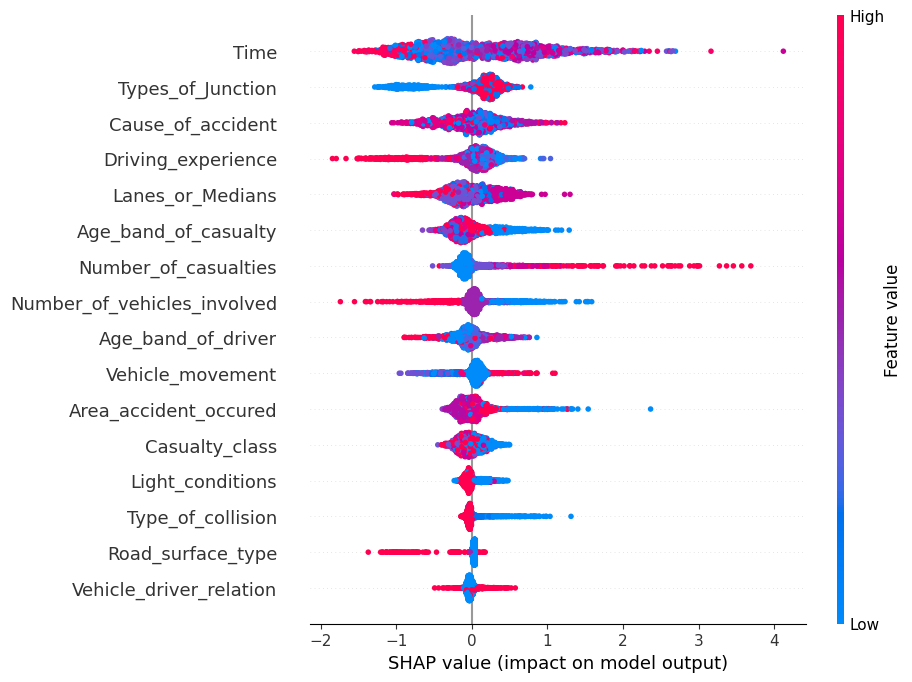

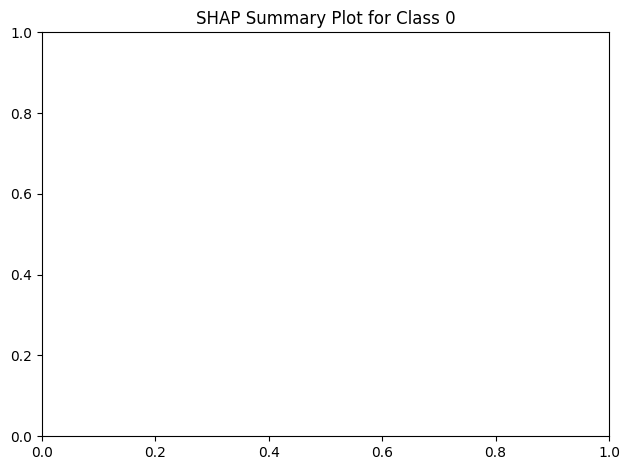


📊 SHAP Summary Plot (Beeswarm) for Class 1


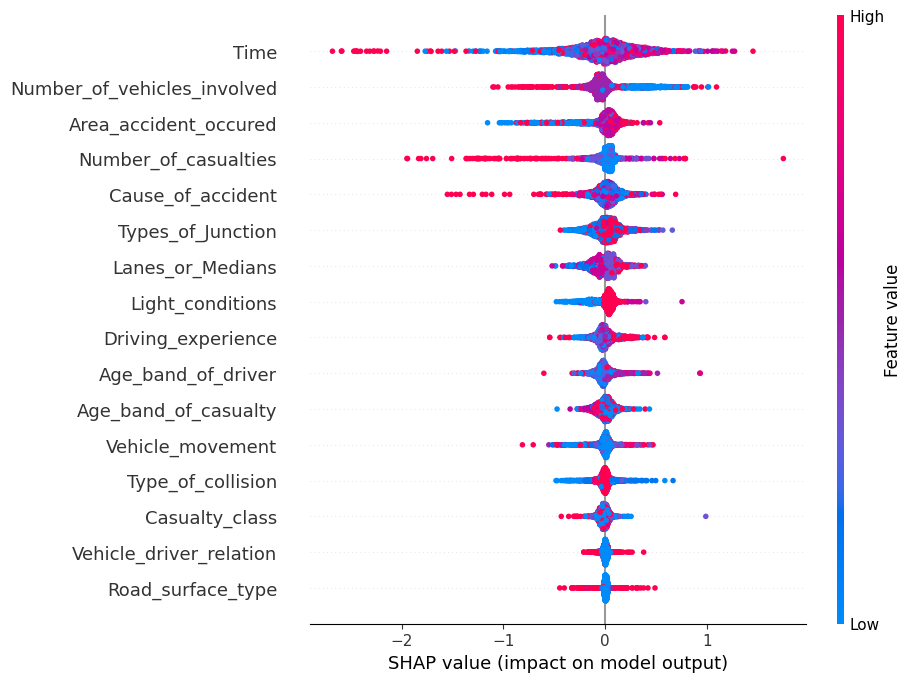

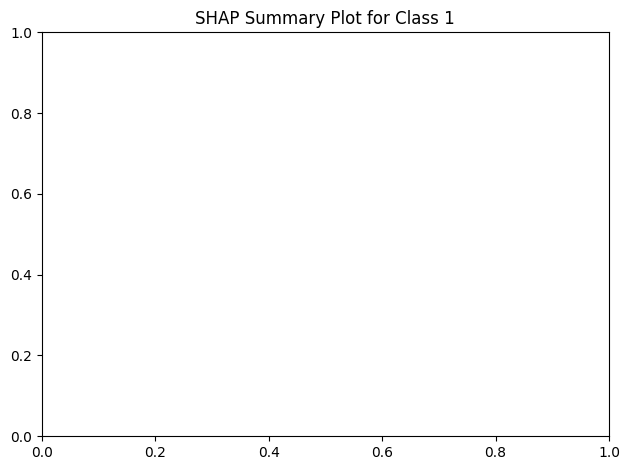


📊 SHAP Summary Plot (Beeswarm) for Class 2


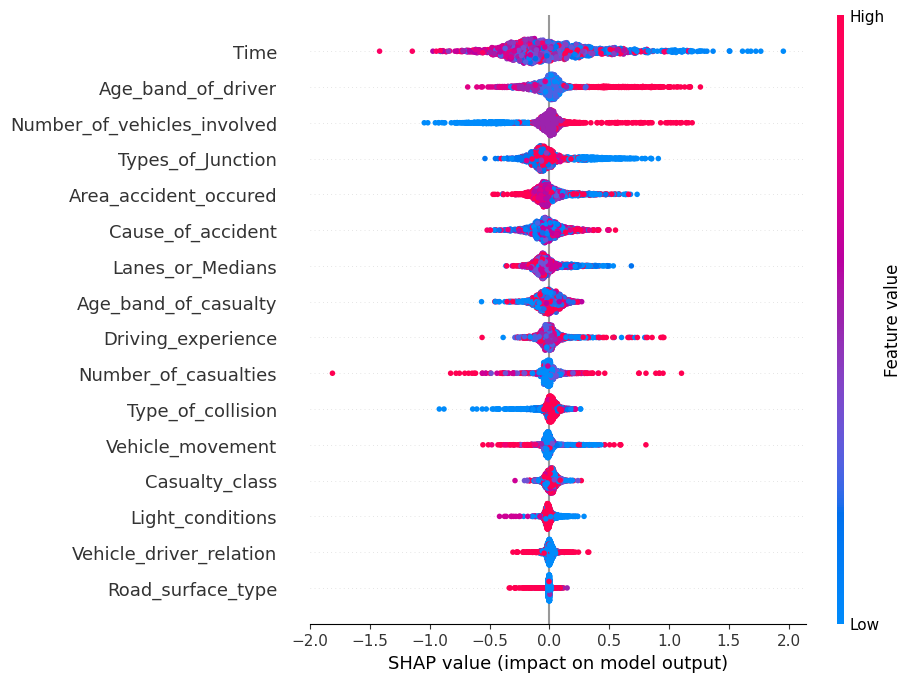

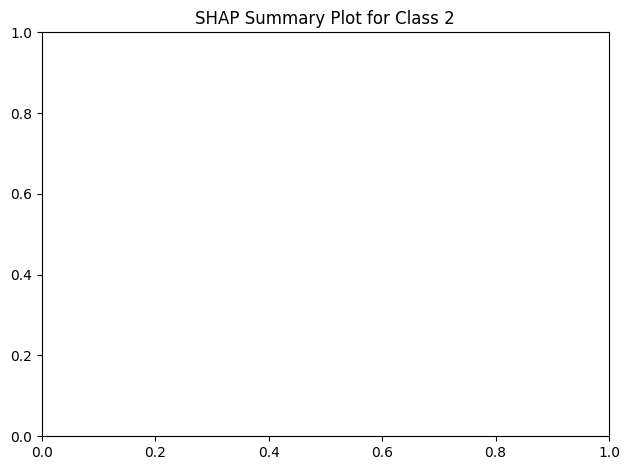

In [6]:
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv('/kaggle/input/road-traffic-accidents/RTA Dataset.csv')

# Selected features and target
selected_features = ['Time', 'Number_of_casualties', 'Number_of_vehicles_involved',
                     'Light_conditions', 'Age_band_of_casualty', 'Type_of_collision',
                     'Age_band_of_driver', 'Road_surface_type', 'Vehicle_driver_relation',
                     'Driving_experience', 'Area_accident_occured', 'Lanes_or_Medians',
                     'Casualty_class', 'Cause_of_accident', 'Types_of_Junction',
                     'Vehicle_movement']
target_column = 'Accident_severity'

# Drop missing values
df = df[selected_features + [target_column]].dropna()

# Encode categorical features
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col].astype(str))

# Define features and target
X = df[selected_features]
y = df[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# SHAP explanation
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Number of classes
num_classes = shap_values.values.shape[2]

# Plot SHAP summary for each class
for class_index in range(num_classes):
    class_shap = shap.Explanation(
        values=shap_values.values[:, :, class_index],
        base_values=shap_values.base_values[:, class_index],
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )

    print(f"\n📊 SHAP Summary Plot (Beeswarm) for Class {class_index}")
    shap.plots.beeswarm(class_shap, max_display=16)
    plt.title(f"SHAP Summary Plot for Class {class_index}")
    plt.tight_layout()
    plt.show()


100%|===================| 5744/5757 [01:06<00:00]       


📊 SHAP Summary Plot (Beeswarm) for Class 0


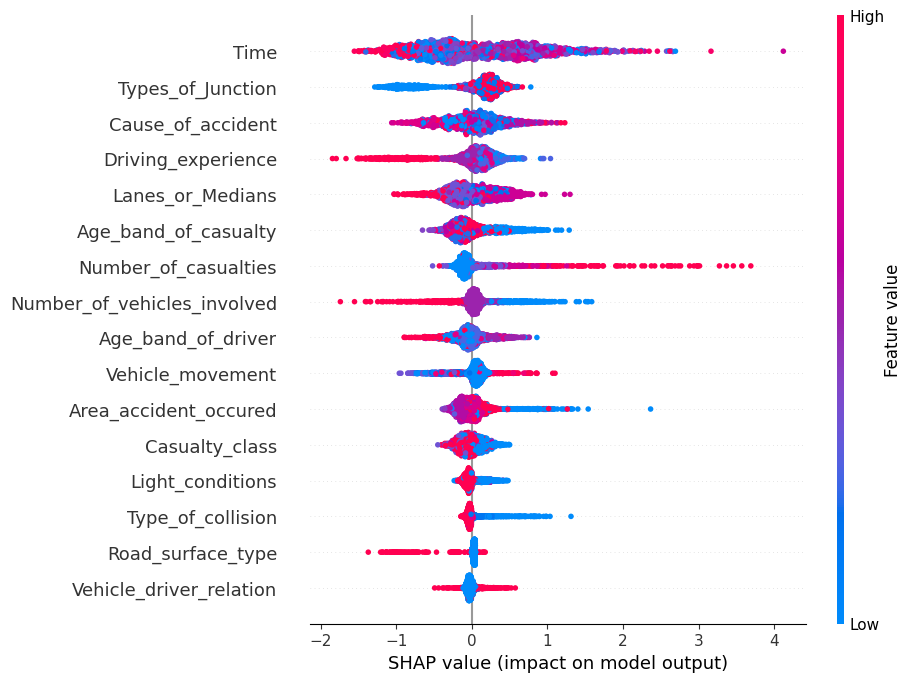

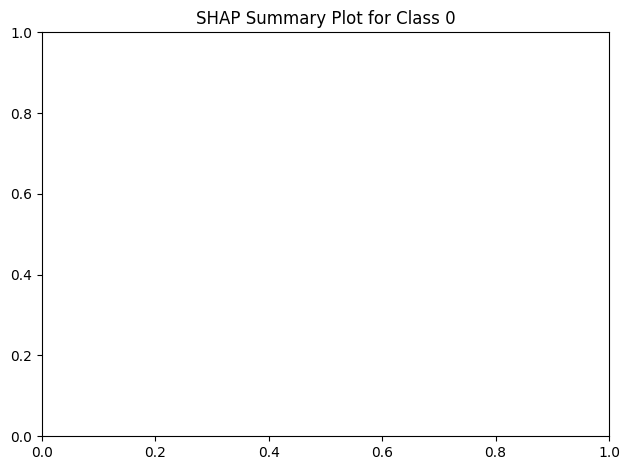


📊 SHAP Summary Plot (Beeswarm) for Class 1


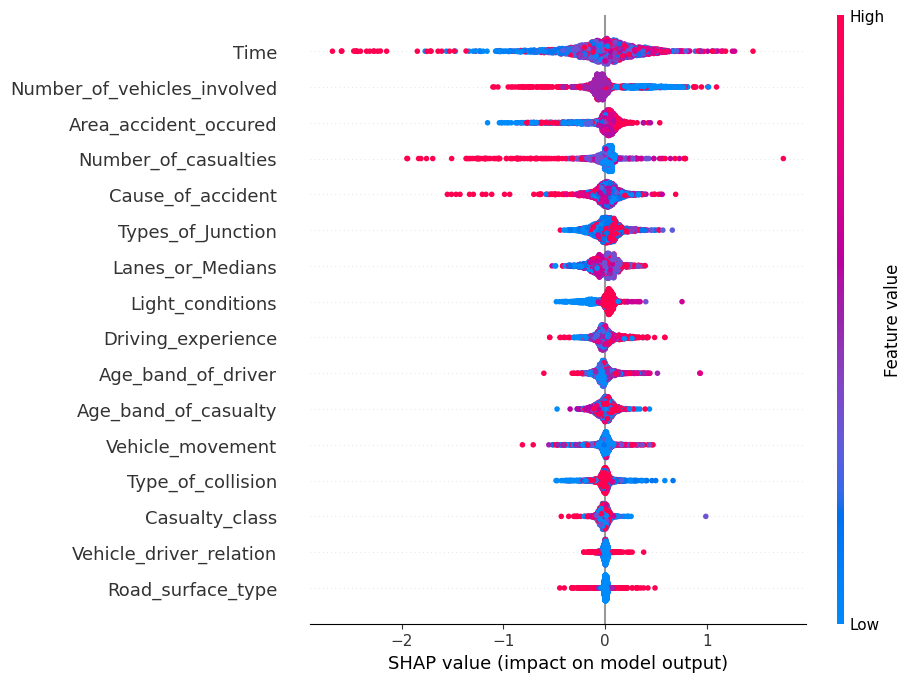

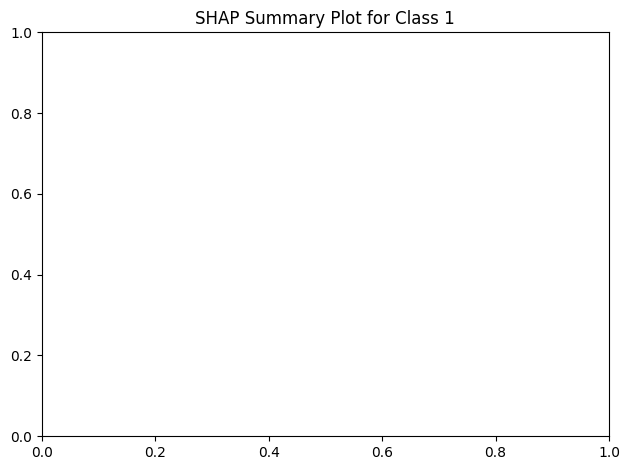


📊 SHAP Summary Plot (Beeswarm) for Class 2


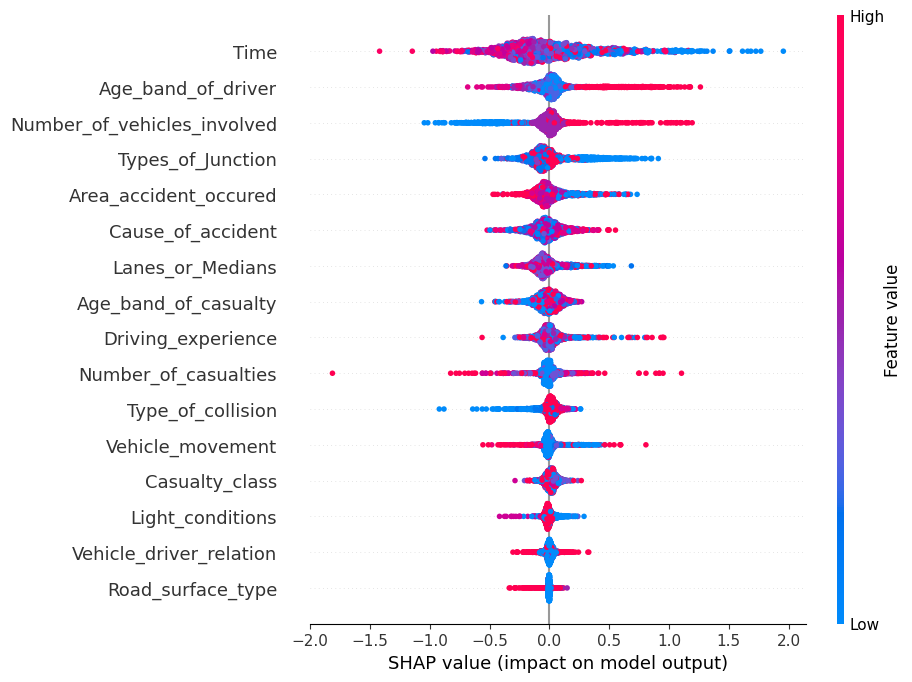

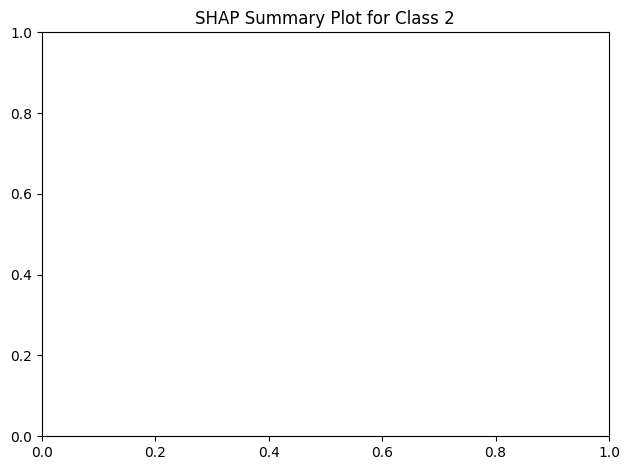

In [7]:
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv('/kaggle/input/road-traffic-accidents/RTA Dataset.csv')

# Selected features and target
selected_features = ['Time', 'Number_of_casualties', 'Number_of_vehicles_involved',
                     'Light_conditions', 'Age_band_of_casualty', 'Type_of_collision',
                     'Age_band_of_driver', 'Road_surface_type', 'Vehicle_driver_relation',
                     'Driving_experience', 'Area_accident_occured', 'Lanes_or_Medians',
                     'Casualty_class', 'Cause_of_accident', 'Types_of_Junction',
                     'Vehicle_movement']
target_column = 'Accident_severity'

# Drop missing values
df = df[selected_features + [target_column]].dropna()

# Encode categorical features
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col].astype(str))

# Define features and target
X = df[selected_features]
y = df[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# SHAP explanation
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Number of classes
num_classes = shap_values.values.shape[2]

# Plot SHAP summary for each class
for class_index in range(num_classes):
    class_shap = shap.Explanation(
        values=shap_values.values[:, :, class_index],
        base_values=shap_values.base_values[:, class_index],
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )

    print(f"\n📊 SHAP Summary Plot (Beeswarm) for Class {class_index}")
    shap.plots.beeswarm(class_shap, max_display=16)
    plt.title(f"SHAP Summary Plot for Class {class_index}")
    plt.tight_layout()
    plt.show()


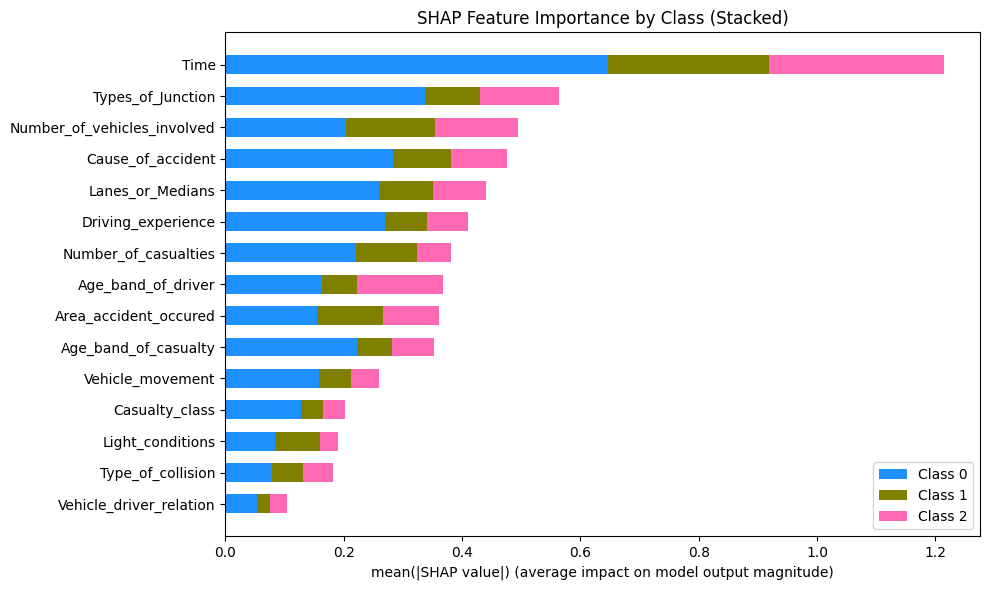

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you've already done preprocessing, training, and:
# explainer = shap.Explainer(model, X_train)
# shap_values = explainer(X_test)

# Extract SHAP values per class
shap_array = shap_values.values  # shape: (n_samples, n_features, n_classes)
feature_names = shap_values.feature_names
num_classes = shap_array.shape[2]

# Calculate mean(|SHAP|) for each class & feature
mean_shap = np.abs(shap_array).mean(axis=0)  # shape: (n_features, n_classes)

# Sort features by total importance (sum over all classes)
total_shap = mean_shap.sum(axis=1)
sorted_idx = np.argsort(total_shap)[::-1]

# Top N features
top_n = 15
top_idx = sorted_idx[:top_n]
top_features = [feature_names[i] for i in top_idx]

# Plot
colors = ['dodgerblue', 'olive', 'hotpink']
class_labels = ['Class 0', 'Class 1', 'Class 2']

fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(top_n)
for class_i in range(num_classes):
    values = mean_shap[top_idx, class_i]
    ax.barh(range(top_n), values, left=bottom, height=0.6, label=class_labels[class_i], color=colors[class_i])
    bottom += values

ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features)
ax.invert_yaxis()
ax.set_xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
ax.set_title("SHAP Feature Importance by Class (Stacked)")
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()
